In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [ ]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.first = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        self.second = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Linear(400, 10)
        
    def forward(self, x):
        out = self.first(x)  # batches, channels, (n, m)
        out = self.second(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return F.log_softmax(out, dim=-1)

In [ ]:
def mixup(x, y, alpha=1.0, size=batch_size):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    size = min(size, x.size(0))
    batch_size = x.size()[0]
    index = torch.randperm(size)
    

    mixup_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixup_x, y_a, y_b, lam


def mixup_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion()(pred, y_a) + (1 - lam) * criterion()(pred, y_b)


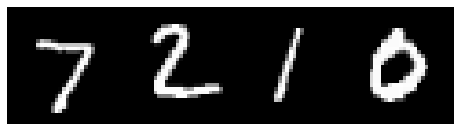

[7 2 1 0]


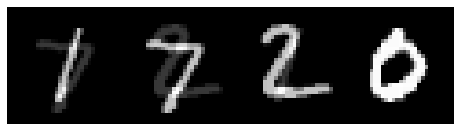

In [ ]:
inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]

def imshow(images):
    img = images
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
imshow(inputs)
print(labels.numpy())

mixed, _, _, _ = mixup(inputs, labels, alpha=0.5, size=4)

imshow(mixed)

In [ ]:
#!g1.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#!g1.1
from tqdm import trange

        
def train_epoch(model, optimizer, batchsize=32, use_mixup=True, alpha=0.5):
    loss_log, acc_log = [], []
    model.train()
    for _, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):
        data = x_batch
        target = y_batch
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)   
        if use_mixup:
            data, targets_a, targets_b, lam = mixup(data, target, alpha)
            data, targets_a, targets_b = map(Variable, (data,
                                                      targets_a, targets_b))
        
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, target).float().mean()
        acc_log.append(acc)
        
        if use_mixup:
            loss = mixup_loss(nn.NLLLoss, output, targets_a, targets_b, lam)
        else:
            loss = nn.NLLLoss()(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):  
        data = x_batch
        target = y_batch
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = model(data)
        loss = nn.NLLLoss()(output, target)
        
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, target).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs, use_mixup=True, alpha=0.5):
    best_acc = 0
    best_wts = None
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch", epoch)
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize, use_mixup=use_mixup, alpha=alpha)

        val_loss, val_acc = test(model)
        mean_acc = torch.mean(torch.Tensor(val_acc))
        clear_output()
        print(f"Current cccuracy is {mean_acc}")
        if mean_acc > best_acc:
            print(f"Best accuracy now is {mean_acc}")
            best_acc = mean_acc
            best_wts = model.state_dict()
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(train_dataset.targets) / batch_size
        val_log.append((steps * (epoch + 1), torch.mean(torch.Tensor(val_loss)).float().cpu().numpy()))
        val_acc_log.append((steps * (epoch + 1), torch.mean(torch.Tensor(val_acc)).float().cpu().numpy()))

        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
    model.load_state_dict(best_wts)        
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

Current cccuracy is 0.98193359375


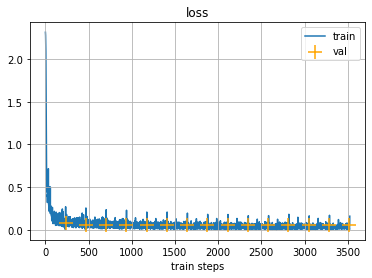

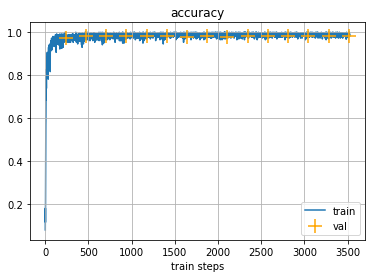

Final error: 1.81%
CPU times: user 3min 8s, sys: 2.33 s, total: 3min 10s
Wall time: 3min 10s


In [ ]:
#!g1.1
%%time

model_no_mixup = ConvNet()
model_no_mixup.to(DEVICE)
opt = optim.Adam(model_no_mixup.parameters(), lr=0.01, weight_decay=1e-4)
train(model_no_mixup, opt, 15, use_mixup=False)

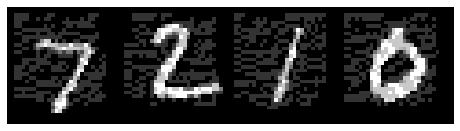

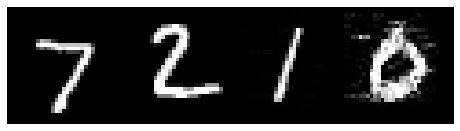

In [ ]:
#!g1.1
import torchvision

def corrupt_sign(inputs, labels, model, weight):
    model.zero_grad()
    var_inputs = Variable(inputs, requires_grad=True)
    F.nll_loss(model(var_inputs), labels).backward()
    var_inputs = var_inputs + weight * torch.sign(var_inputs.grad)
    return torch.clamp(var_inputs, min=0, max=1)
    
    return corrupted_inputs

def corrupt_simple(inputs, labels, model, weight):
    model.zero_grad()
    var_inputs = Variable(inputs, requires_grad=True)
    F.nll_loss(model(var_inputs), labels).backward()
    var_inputs = var_inputs + weight * var_inputs.grad 
    return torch.clamp(var_inputs, min=0, max=1)

inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)

corrupted_inputs = corrupt_sign(inputs, labels, model_no_mixup, 0.2)
imshow(corrupted_inputs.data.cpu()) 

corrupted_inputs = corrupt_simple(inputs, labels, model_no_mixup, 2000)
imshow(corrupted_inputs.data.cpu()) 

In [ ]:
#!g1.1
def evaluate_network_attack(net, corrupt_function, weight, verbose=True):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        images = corrupt_function(images, labels, net, weight)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).long().squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
    accuracy = (100. * sum(class_correct) / sum(class_total))
    if verbose:
        print('Accuracy %d %% \n' % (100. * sum(class_correct) / sum(class_total)))
        
        for i in range(10):
            print('Accuracy of %2s : %2d %%' % (
                i, 100. * class_correct[i] / class_total[i]))
    return accuracy

In [ ]:
#!g1.1
print('Without corruption:')
evaluate_network_attack(model_no_mixup, corrupt_sign, 0)
print('\n================\n')
print('With corruption:')
evaluate_network_attack(model_no_mixup, corrupt_sign, 0.2)

Without corruption:
Accuracy 98 % 

Accuracy of  0 : 100 %
Accuracy of  1 : 94 %
Accuracy of  2 : 100 %
Accuracy of  3 : 100 %
Accuracy of  4 : 100 %
Accuracy of  5 : 90 %
Accuracy of  6 : 100 %
Accuracy of  7 : 93 %
Accuracy of  8 : 100 %
Accuracy of  9 : 100 %


With corruption:
Accuracy 23 % 

Accuracy of  0 : 15 %
Accuracy of  1 : 41 %
Accuracy of  2 : 33 %
Accuracy of  3 : 12 %
Accuracy of  4 : 50 %
Accuracy of  5 : 10 %
Accuracy of  6 : 21 %
Accuracy of  7 : 26 %
Accuracy of  8 : 14 %
Accuracy of  9 :  0 %


23.75

Current cccuracy is 0.9593750238418579


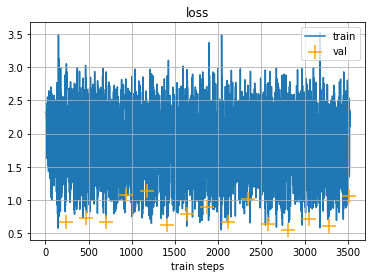

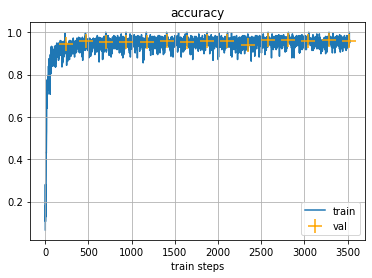

Final error: 4.06%
Accuracy 33 % 

Accuracy of  0 : 61 %
Accuracy of  1 : 94 %
Accuracy of  2 : 22 %
Accuracy of  3 : 25 %
Accuracy of  4 : 22 %
Accuracy of  5 :  0 %
Accuracy of  6 : 50 %
Accuracy of  7 : 40 %
Accuracy of  8 : 14 %
Accuracy of  9 :  4 %


In [ ]:
#!g1.1
results = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_mixup = ConvNet()
    model_mixup.to(DEVICE)
    opt = optim.Adam(model_mixup.parameters(), lr=0.01, weight_decay=1e-4)
    train(model_mixup, opt, 15, use_mixup=True, alpha=alpha)
    acc = evaluate_network_attack(model_mixup, corrupt_sign, 0.2)
    results[alpha] = acc

In [ ]:
for alpha, acc in results.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

Mixup. Alpha = 0.1, accuracy = 19.375
Mixup. Alpha = 0.2, accuracy = 0.625
Mixup. Alpha = 0.30000000000000004, accuracy = 18.125
Mixup. Alpha = 0.4, accuracy = 30.0
Mixup. Alpha = 0.5, accuracy = 23.75
Mixup. Alpha = 0.6, accuracy = 11.25
Mixup. Alpha = 0.7000000000000001, accuracy = 29.375
Mixup. Alpha = 0.8, accuracy = 6.25
Mixup. Alpha = 0.9, accuracy = 35.625
Mixup. Alpha = 1.0, accuracy = 33.125


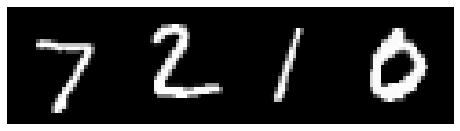

In [ ]:
#!g1.1
inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)
corrupted_inputs = corrupt_simple(inputs, labels, model_no_mixup, 0.1)
imshow(corrupted_inputs.cpu().data) 

In [ ]:
#!g1.1
evaluate_network_attack(model_no_mixup, corrupt_simple, 0.1)

Accuracy 98 % 

Accuracy of  0 : 92 %
Accuracy of  1 : 100 %
Accuracy of  2 : 94 %
Accuracy of  3 : 100 %
Accuracy of  4 : 100 %
Accuracy of  5 : 90 %
Accuracy of  6 : 100 %
Accuracy of  7 : 100 %
Accuracy of  8 : 100 %
Accuracy of  9 : 100 %


98.125

Current cccuracy is 0.9658203125


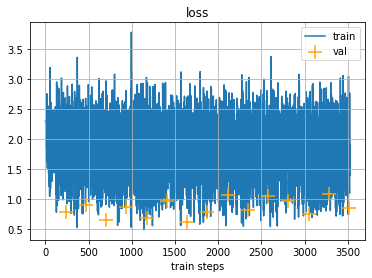

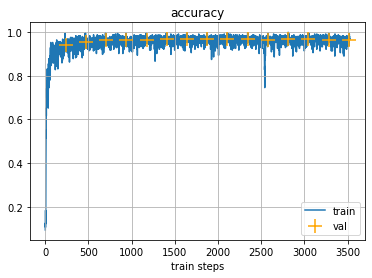

Final error: 3.42%
Accuracy 9 % 

Accuracy of  0 :  0 %
Accuracy of  1 :  5 %
Accuracy of  2 :  5 %
Accuracy of  3 : 25 %
Accuracy of  4 :  0 %
Accuracy of  5 :  0 %
Accuracy of  6 :  7 %
Accuracy of  7 :  0 %
Accuracy of  8 : 57 %
Accuracy of  9 :  0 %
Mixup. Alpha = 0.1, accuracy = 13.125
Mixup. Alpha = 0.2, accuracy = 51.25
Mixup. Alpha = 0.30000000000000004, accuracy = 36.25
Mixup. Alpha = 0.4, accuracy = 2.5
Mixup. Alpha = 0.5, accuracy = 56.875
Mixup. Alpha = 0.6, accuracy = 5.0
Mixup. Alpha = 0.7000000000000001, accuracy = 38.125
Mixup. Alpha = 0.8, accuracy = 16.25
Mixup. Alpha = 0.9, accuracy = 35.0
Mixup. Alpha = 1.0, accuracy = 9.375


In [ ]:
#!g1.1
results_simple = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_mixup = ConvNet()
    model_mixup.to(DEVICE)
    opt = optim.Adam(model_mixup.parameters(), lr=0.01, weight_decay=1e-4)
    train(model_mixup, opt, 15, use_mixup=True, alpha=alpha)
    acc = evaluate_network_attack(model_mixup, corrupt_simple, 2000)
    results_simple[alpha] = acc
for alpha, acc in results_simple.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

In [ ]:
#!g1.1
